# Random Sampling Methods for Uncertainty Propagation
 **Saleh Rezaeiravesh and Philipp Schlatter** <br/> 
 saleh.rezaeiravesh@manchester.ac.uk and pschlatt@mech.kth.se <br/> 
 Modelling & Simulation, Department of Mechanical, Aerospace and Civil Engineering (MACE), The University of Manchester, UK <br/> 
 SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Sweden
___

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('./modules/')
import grafix
import sampling
import sobol_sequence
import rosenbrock

### Learning Objectives
* How sample-based methods for uncertainty propagation work,
* Impact of the sampling method and number of samples on the convergence rate of the stochastic moments,
* Pros and cons of the sampling methods for uncertainty propagation as compared to the perturbation method.

## Sampling Methods
Consider 

$$
\begin{equation}
y=f(\mathbf{q},\chi) \,,
\end{equation}
$$

where $\mathbf{q}\in \mathbb{Q}\subset \mathbb{R}^p$ are uncertain parameters and $\chi$ are design variables.
Given the joint distribution of the uncertain parameters, sampling methods can be used to evaluate the propagation of the uncertainties in the model response $f(\mathbf{q})$. The sampling methods do not require any linearization but can be computationally expensive (blackbox evaluation). 

In this notebook, we study the uncertainty propagation by sampling methods and discuss various relevant important points through the examples. 

### Example: Algebraic Model, 1 parameter

Consider an algebraic model function which depends only on one parameter:
$$
y=f(q)=q+0.7 \sin(5 q) + 3 \cos(q)\,,
$$
where $q\sim \mathcal{N}(1,0.3^2)$. 

Drawing samples for $q$ from the Gaussian distribution and evaluating the model function at each sample are implemented below.

In [2]:
n=100000
q=np.random.normal(loc=1,scale=0.3,size=n)
y=q+0.7*np.sin(5*q)+3*np.cos(q)

The mean and variance of the response are estimated as:

In [3]:
print('E[f(q)]=%g and V[f(q)]=%g'  %(np.mean(y),np.var(y)))

E[f(q)]=2.32963 and V[f(q)]=0.230092


The model response can be plotted as:

Text(0, 0.5, 'y')

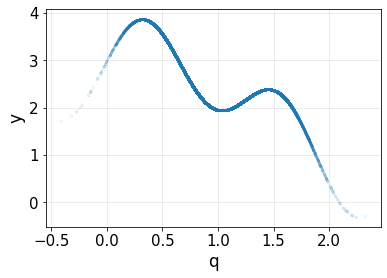

In [4]:
#plot model function 
plt.plot(q,y,'o',alpha=0.1,ms=2,mfc='none')
plt.grid(alpha=0.3)
plt.xlabel('q')
plt.ylabel('y')

Clearly, we are working with a non-linear model (in terms of $q$), therefore as shown below, the Gaussian distribution of $q$ leads to a non-trivial distribution for $y=f(q)$. In contrast, when adopting perturbation methods, we only map one point (mean or a nominal value of $q$) to the mean of $f(q)$.
These important points can be understood from the following plots.

Text(0.5, 0, 'y')

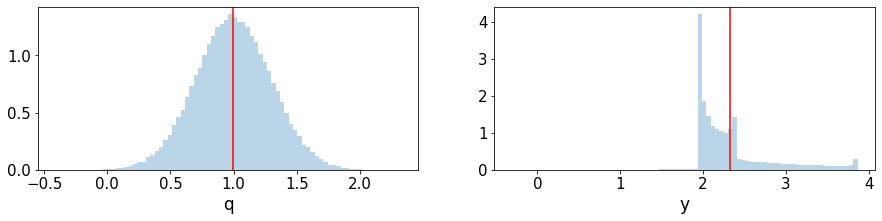

In [5]:
plt.figure(figsize=(15,3))
plt.subplot(121)
_=plt.hist(q,density=True,bins=80,alpha=0.3)
plt.axvline(x=np.mean(q),color='red')
plt.xlabel('q')
plt.subplot(122)
_=plt.hist(y,density=True,bins=80,alpha=0.3)
plt.axvline(x=np.mean(y),color='red')
plt.xlabel('y')

### Example: Algebraic Model, 2 parameters
We revisit the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) which is an algebraic model with two parameters $q_1$ and $q_2$:
$$
\begin{equation}
f(q_1,q_2) = a(q_2-q_1^2)^2 + (b-q_1)^2  \,,
\end{equation}
$$
where $a$ and $b$ are two fixed constants with default values $a=100$ and $b=1$.


First, let us look at the model response in the $q_1-q_2$ plane over a given range of these parameters.

In [6]:
q_bound=[[-2,2],   #range of q1
         [-2,2]]   #range of q2 

#Constants in Rosenbrock function
a=100
b=1

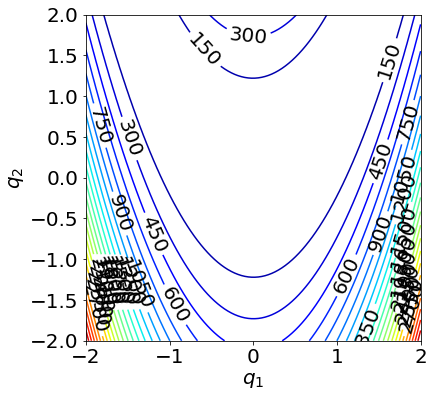

In [7]:
#Rosenbrock function
Rsbrk = lambda a,b,q1, q2 : a*(q2-q1**2)**2+(b-q1)**2

#plot Exact Rosenbrock
q1_ex=np.linspace(q_bound[0][0],q_bound[0][1],100)
q2_ex=np.linspace(q_bound[1][0],q_bound[1][1],101)

q_ex_grid=np.vstack(np.meshgrid(q1_ex,q2_ex)).reshape(2,-1).T

y_ex=Rsbrk(a,b,q_ex_grid[:,0],q_ex_grid[:,1])
y_ex=np.reshape(y_ex,(q1_ex.size,q2_ex.size),order='F')

plt.figure(figsize=[6,6])
ax=plt.gca()
CS = plt.contour(q1_ex,q2_ex,y_ex.T,30,cmap='jet')
plt.clabel(CS, inline=True, fontsize=20,colors='k',fmt='%d',rightside_up=True,manual=False)
plt.xlabel(r'$q_1$',fontsize=20)
plt.ylabel(r'$q_2$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

Assume $q_1$ and $q_2$ are uniformly distributed as $q_1\sim\mathcal{U}[q_{1_L},q_{1_R}]$ and $q_2\sim\mathcal{U}[q_{2_L},q_{2_R}]$. Also, assume these parameters are mutually independent. 

To estimate the distribution of the response function $y=f(\mathbf{q})$, we need to draw sufficiently large number of random samples from the joint distribution of $q_1$ and $q_2$.

This is simply implemented in `Rsbrk_MC_FWD()`.

In [8]:
def Rsbrk_MC_FWD(a,b,nMC,q_bound):
    """
    Estimate mean and variance of the Rosenbrock function using random samples
    for q1~U[q_bound[0]] and q2~U[q_bound[1]]
    """
    q=np.zeros((nMC,2))
    for i in range(2): 
        q[:,i]=np.random.uniform(low=q_bound[i][0], high=q_bound[i][1], size=[nMC])
    
    y_mc=Rsbrk(a,b,q[:,0],q[:,1])
    m=np.sum(y_mc)/float(nMC)  ## or np.mean(y_mc)
    v=np.std(y_mc)**2
    return m,v

Call the function for `nMC` number of samples and estimate stochastic modments of the response functon:

In [9]:
nMC=10000   #number of MC samples

y_mc_mean,y_mc_var=Rsbrk_MC_FWD(a,b,nMC,q_bound)

print('MC estimates:')
print('E[f(q)]=%g , V[f(q)]=%g' %(y_mc_mean,y_mc_var))

MC estimates:
E[f(q)]=457.716 , V[f(q)]=365032


If we try different values of `nMC`, different etimates for the stochastic moments of $f(\mathbf{q})$ are obtained. But how accurate the estimated moments are?
For the given problem, with independent uniform distributions for $q_1$ and $q_2$, we can derive close expressions for the mean and variance for $f(\mathbf{q})$. The resulting values can be used as true values to evaluate the accuracy of the estimated moments by random sampling. 

The exact $\mathbb{E}[f(\mathbf{q})]$ and $\mathbb{V}[f(\mathbf{q})]$ of the Rosenbrock function for $q_1\sim\mathcal{U}[q_{1_L},q_{1_R}]$ and $q_2\sim\mathcal{U}[q_{2_L},q_{2_R}]$ can be derived from,

$$
\begin{eqnarray}
\mathbb{E}[y] &=& \int \int f(q_1,q_2) \rho(q_1,q_2) dq_1d q_2 =
\frac{1}{q_{1_R}-q_{1_L}}\cdot\frac{1}{q_{2_R}-q_{2_L}} \int_{q_{2_L}}^{q_{2_R}}\int_{q_{1_L}}^{q_{1_R}} f(q_1,q_2)dq_1d q_2 \,, \\
\mathbb{V}[y] &=& \int \int (f(q_1,q_2)-\mathbb{E}[y])^2 \rho(q_1,q_2) dq_1d q_2 \,, \\
\end{eqnarray}
$$

We have calculated the exact moments of the Rosenbrock function and provided it in a separate python script `rosenbrock.exactMoments()`. 

In [10]:
mExct,vExct=rosenbrock.exactMoments(a,b,q_bound)
print("Exact moments:")
print('E[f(q)]=%g , V[f(q)]=%g' %(mExct,vExct))

Exact moments:
E[f(q)]=455.667 , V[f(q)]=367915


### Confidence in the Estimated Stochastic Moments
Due to the use of random samples, it is trivial that every time we run the algorithm, different estimates for the stochastic moments of the model function are obtained. 
Here, through repeating the algorithm, we can estimate the uncertainty in the estimated moments.

In [11]:
nRepeat=1000   #number of repetitions
nMC=1000       #number of samples in each realization
m_MC=np.zeros(nRepeat)
v_MC=np.zeros(nRepeat)
for i in range(nRepeat):
    m_MC[i],v_MC[i]=Rsbrk_MC_FWD(a,b,nMC,q_bound)

We can look at the histograms of the mean and variance of $f(\mathbf{q})$:

Estimated E[f(q)] = 456.041 +/- 37.183
Estimated V[f(q)] = 369369 +/- 55050.7


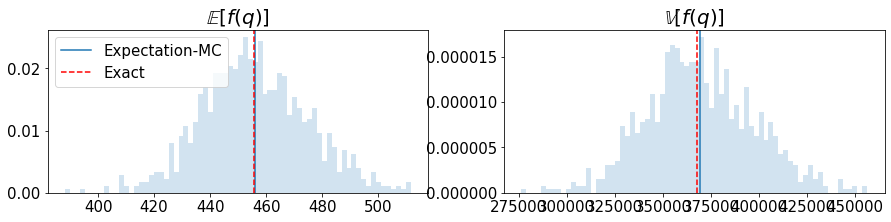

In [12]:
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.title(r'$\mathbb{E}[f(q)]$',fontsize=20)
_=plt.hist(m_MC,bins=70,density=True,alpha=0.2)
plt.axvline(x=np.mean(m_MC),label='Expectation-MC')
plt.axvline(x=mExct,ls='--',color='r',label='Exact')
plt.legend()
print("Estimated E[f(q)] = %g +/- %g" %(np.mean(m_MC),1.96*np.std(m_MC)))

plt.subplot(122)
plt.title(r'$\mathbb{V}[f(q)]$',fontsize=20)
_=plt.hist(v_MC,bins=70,density=True,alpha=0.2)
plt.axvline(x=np.mean(v_MC))
plt.axvline(x=vExct,ls='--',color='r',label='Exact')
print("Estimated V[f(q)] = %g +/- %g" %(np.mean(v_MC),1.96*np.std(v_MC)))

**Discussion** 
* Try different values for `nRepeat` and `nMC`. What are your observations?
* What are your conclusions about the MC method for the UQ forward problem?

### Convergence of the Stochastic Moments Using Different Sampling Methods

For sampling we have various options including the following:
* Monte Carlo (MC) method (as above), 
* [Latin-hypercube sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) (LHS), and
* [Sobol sequence](https://en.wikipedia.org/wiki/Sobol_sequence) which are quasi-random samples.

Here, we use the two latter methods as blackbox without discussing the theory behind them. 
The code for generating Sobol sequence in the present notebook is downloaded from [here (C. Chisari)](https://people.sc.fsu.edu/~jburkardt/py_src/sobol/sobol.html).

Function `Rsbrk_sampling_FWD()` applies these three methods to the Rosenbrock function with independent uniform distributions. 

In [13]:
def Rsbrk_sampling_FWD(a,b,n,q_bound,samplingMethod):
    """
    Estimate mean and variance of the Rosenbrock function using different sampling methods
    for q1~U[q_bound[0]] and q2~U[q_bound[1]]
    samplingMethod: string
       'MC': standard pseudorandom samples
       'LHS': Latin Hypercube Sampling
       'Sobol': Sobol sequence
    """
    if samplingMethod=='MC':       
       q=np.zeros((n,2))
       for i in range(2): 
           q[:,i]=np.random.uniform(low=q_bound[i][0], high=q_bound[i][1], size=[n])      
    elif samplingMethod=='LHS':
       q=sampling.LHS_sampling(n,q_bound)    
    elif samplingMethod=='Sobol':
       skip=0 
       q=sobol_sequence.i4_sobol_generate( 2, n, skip ).T 
       for i in range(2):
           q[:,i]=q[:,i]*(q_bound[i][1]-q_bound[i][0])+q_bound[i][0]
    
    y=Rsbrk(a,b,q[:,0],q[:,1])
    m=np.mean(y)  ## or np.sum(y)/float(n)
    v=np.var(y)
    return m,v,q

Let us first look at samples generated by each of these methods:

414.8017148355399 316068.6682701211
449.14124159008 335628.12209964765
459.77073022724596 381328.38376988407


Text(0.5, 1.0, 'Sobol Sequence')

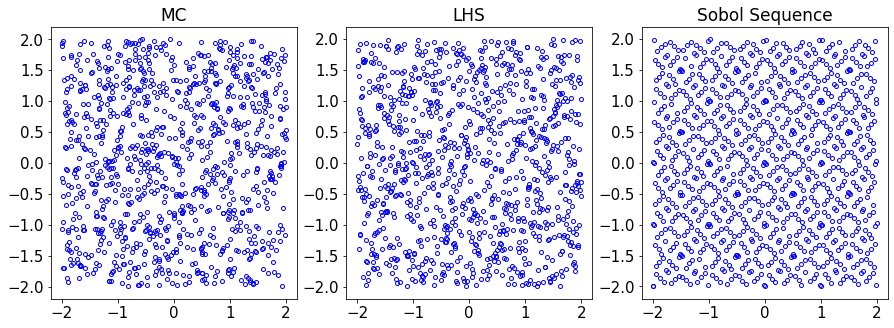

In [14]:
n=1000 #number of samples
m_,v_,qMC=Rsbrk_sampling_FWD(a,b,n,q_bound,'MC')
print(m_,v_)
m_,v_,qLHS=Rsbrk_sampling_FWD(a,b,n,q_bound,'LHS')
print(m_,v_)
m_,v_,qSobol=Rsbrk_sampling_FWD(a,b,n,q_bound,'Sobol')
print(m_,v_)

#plot
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(qMC[:,0],qMC[:,1],'ob',ms=4)
plt.title('MC')
plt.subplot(132)
plt.plot(qLHS[:,0],qLHS[:,1],'ob',ms=4)
plt.title('LHS')
plt.subplot(133)
plt.plot(qSobol[:,0],qSobol[:,1],'ob',ms=4)
plt.title('Sobol Sequence')

The aim of the following script is to study the rate of convergence of the mean and variance of $f(\mathbf{q})$ for the Rosenbrock function with number of samples generated by different sampling methods.
To this end, the error between the estimated moments and corresponding exact values is plotted for different number of samples.
Note that for a large number of samples, the script may run slowly. 

Text(0, 0.5, 'Error in $\\mathbb{V}[f(q)]$')

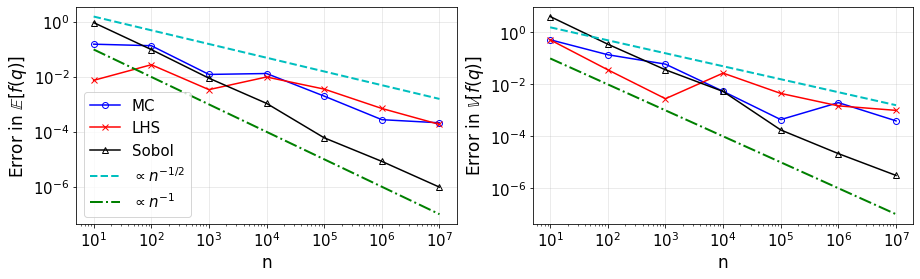

In [15]:
nList=[10,100,1000,10000,100000,1000000,10000000]  #list of number of samples
m_MC=[]
v_MC=[]
m_LHS=[]
v_LHS=[]
m_Sobol=[]
v_Sobol=[]

for n in nList:
    m_,v_,_=Rsbrk_sampling_FWD(a,b,n,q_bound,'MC')    
    m_MC.append(abs(m_-mExct)/mExct) 
    v_MC.append(abs(v_-vExct)/vExct) 
    
    m_,v_,_=Rsbrk_sampling_FWD(a,b,n,q_bound,'LHS')
    m_LHS.append(abs(m_-mExct)/mExct) 
    v_LHS.append(abs(v_-vExct)/vExct)   
    
    m_,v_,_=Rsbrk_sampling_FWD(a,b,n,q_bound,'Sobol')
    m_Sobol.append(abs(m_-mExct)/mExct)
    v_Sobol.append(abs(v_-vExct)/vExct)     
    
#plot
nList=np.asarray(nList)
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.loglog(nList,m_MC,'-ob',label='MC')
plt.loglog(nList,m_LHS,'-xr',label='LHS')
plt.loglog(nList,m_Sobol,'-^k',label='Sobol')
plt.loglog(nList,5./np.sqrt(nList),'--c',lw=2,label=r'$\propto n^{-1/2}$')
plt.loglog(nList,1./nList,'-.g',lw=2,label=r'$\propto n^{-1}$')
plt.legend()
plt.grid()
plt.xlabel('n')
plt.ylabel(r'Error in $\mathbb{E}[f(q)]$')

plt.subplot(122)
plt.loglog(nList,v_MC,'-ob',label='MC')
plt.loglog(nList,v_LHS,'-xr',label='LHS')
plt.loglog(nList,v_Sobol,'-^k',label='Sobol')
plt.loglog(nList,5./np.sqrt(nList),'--c',lw=2,label=r'$\propto n^{-1/2}$')
plt.loglog(nList,1./nList,'-.g',lw=2,label=r'$\propto n^{-1}$')
plt.grid()
plt.xlabel('n')
plt.ylabel(r'Error in $\mathbb{V}[f(q)]$')

**Discussion**
* What is your conclusion about the convergence rates? What is the approximate rate of convergence of each method?
* What would be your choice for sampling method for a UQ forward problem? Motivate you answer. 

## Hands-on 1: Damped Harmonic Oscillator

Consider the simple system consisting of a mass $m$, a damper with damping coefficient $c$, and a spring with constant $k$. For oscillations with no forcing in the vertical direction, the dynamics of the system is described by the following 2nd-order ODE:
    
$$
\begin{equation}
\ddot{y} + C \dot{y} + K y =0 \,, \quad y(0)=y_0 \,, \dot{y}(0)=v_0
\end{equation}
$$

where $y$ is the distance from the fixed point measured downward, $C=c/m$, and $K=k/m$. The analytical solution for the above ODE is,

$$
\begin{equation}
   y(t)=\exp(-C\,t/2) \left(c_1\cos(\omega t) + c_2 \sin(\omega t) \right)
\end{equation}
$$

where $c_1=y_0$, $c_2=(v_0+C y_0/2)/\omega$, and $\omega = \sqrt{K-C^2/4}$. 

* Assume all the four parameters $\mathbf{q}=[K,C,y_0,v_0]$ are mutually independent and have Gaussian distributions. We aim at seeing how much uncertainty from these parameters would propoagate into the response $y(t)$ at different times. 
In particular, try $K\sim\mathcal{N}(20,1^2)$, $C\sim\mathcal{N}(1,0.1^2)$, $y_0\sim\mathcal{N}(0,0.15^2)$,  $v_0\sim\mathcal{N}(1,0.1^2)$, and $t\in[0,6]$.

* Repeat above, assuming two or more parameters are correlated. 

In [16]:
def harmOscil(t,K,C,y0,v0): 
    """
    Returns y(t) of simple harmonic oscillator
    """
    omeg=np.sqrt(K-C**2/4)
    c2=(v0+C*y0/2)/omeg
    y=np.exp(-0.5*C*t)*(y0*np.cos(omeg*t)+c2*np.sin(omeg*t))
    return y

## Hands-on 2: Lorenz System

The [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) is a system of three ODEs:
$$
\begin{eqnarray}
\dot{x}&=&\alpha(y-x) \\ 
\dot{y}&=&x(\rho-z)-y \\
\dot{z}&=&xy-\beta z
\end{eqnarray}
$$
with initial condition $x(0)=x_0$, $y(0)=y_0$, and $z(0)=z_0$. Note that $\dot{}=d/dt$. For some combinations of parameters $\mathbf{q}=[\alpha,\rho,\beta]$, the solution shows chaotic behavior. 


The function `lorenz_solver()` provides a numerical solution for the Lorenz equations. 

In [17]:
def lorenz_solver(x0,par,dt,nt,nt_burn):
    """
    Solution of the Lorenz system
    Args:
      `x0`: 3-by-1 numpy array, initial condition
      `par`: list of length 3, parameters [sigma, rho, beta]
      `dt`: float, time step size (NOTE: dt>0)
      `nt`: int, number of time steps to solve
      `nt_burn`: int, number of initial time steps to remove 
    Returns:
       `t`: numpy array of size `nt-nt_burn`, time
       `x`: numpy array of size `nt-nt_burn` by `3`, solution variables
    """
    nt_total=nt+nt_burn
    t,x=rk4Solver(x0,dt,nt_total,par)
    return t[nt_burn:]-t[nt_burn],x[nt_burn:,:]

def rhs_lorenz(x,t,par):
    """ 
    Builds the RHS of the Lorenz system dX/dt=f(X(t)) 
    Args:
      `t`: float, time
      `x`: numpy 3-by-1 vector, solution variable
      `par`: =[sigma,rho,beta] parameters in the Lorenz equations
    Return
      `rhs`: list of length 3, the RHS of the Lorenz system
    """
    rhs=np.zeros(len(x))
    rhs[0]=par[0]*(x[1]-x[0])
    rhs[1]=x[0]*(par[1]-x[2])-x[1]
    rhs[2]=x[0]*x[1]-par[2]*x[2]
    return rhs

def rk4Solver(x0,dt,nt,par):
    """ 
    RK4 solver for an ODE system
    Args:
      `x0`: d-by-1 numpy array, initial condition
      `dt`: float, time step size (NOTE: dt>0)
      `nt`: int, number of time steps to solve
      `par`: list, parameters
    Returns:
       `t`: numpy array of size `nt`, time
       `x`: numpy array of size `nt` by `d`, solution variables
    """
    t=np.zeros(nt);
    d=len(x0)
    x=np.zeros((nt,d));
    x[0,:]=x0
    for i in range(1,nt):
        im=i-1;
        k1=rhs_lorenz(x[im,:],t[im],par)
        k2=rhs_lorenz(x[im,:]+0.5*dt*k1,t[im]+0.5*dt,par)
        k3=rhs_lorenz(x[im,:]+0.5*dt*k2,t[im]+0.5*dt,par)
        k4=rhs_lorenz(x[im,:]+dt*k3+dt*k1,t[im]+dt,par)
        x[i,:]=x[im,:]+(dt/6.0)*(k1+2.*k2+2.*k3+k4);
        t[i]=t[im]+dt;
    return t,x

The Lorenz system can be numerically solved for a given set of parameters, initial data, and time steps. 
In particular, we can try the solution for $\alpha=10$, $\rho=28$, and $\beta=8/3$ (one can choose any other values for these parameters). 

In [18]:
nt=10000   #number of time steps
nt_burn=0  #if random initial data is used
T=30       #final time
x0=np.asarray([0,0.1,0])   #initial data
par=[10,28,8/3]     #sigma,rho,beta

dt=T/(nt+nt_burn-1)

#call the solver
t,x=lorenz_solver(x0,par,dt,nt,nt_burn)

The evolution of $x$, $y$, and $z$ over time can be plotted:

Text(0.5, 0, 't')

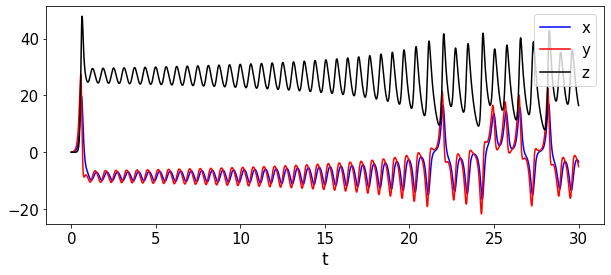

In [19]:
#plot solution
plt.figure(figsize=(10,4))
plt.plot(t,x[:,0],'-b',label='x')
plt.plot(t,x[:,1],'-r',label='y')
plt.plot(t,x[:,2],'-k',label='z')
plt.legend()
plt.xlabel('t')

We can plot the solution in the phase space:

<IPython.core.display.Javascript object>


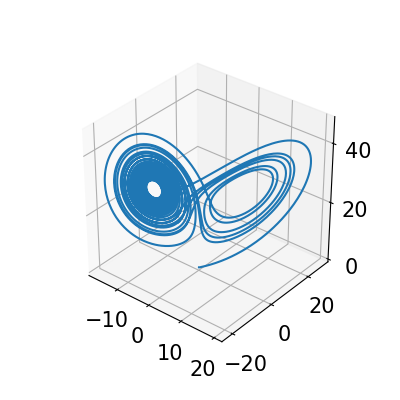

In [20]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure(figsize=(4,4))
ax = fig.gca(projection='3d')
ax.plot(x[:,0],x[:,1],x[:,2])
plt.show()

In this hands-on we are going to apply the sampling method to estimate uncertainty in the solution of the Lorenz system over a given time range. In particular, do the following:

* Task 1: Assume $\alpha~\sim(10,0.1^2)$, $\rho\sim\mathcal{N}(28,0.1^2)$, and $\beta=8/3$ with $[x(0),y(0),z(0)]=[0,0.1,0]$. 
* Task2: Assume $\alpha=10$, $\rho=28$, and $\beta=8/3$ with $[x(0),y(0),z(0)]=[0,y_0,0]$ with $y_0\sim\mathcal{N}(0,0.1^2)$. 

In each case, estimate the mean and variance of $w(t)=\sqrt{x(t)^2+y(t)^2+z(t)^2}$. 

What is your conclusion about the propagation of uncertainty into the solution at different times? When the influence of the uncertain parameters is more significant? 